# Time Series with `pandas`

**Credit:** Notebook created by Eni Mustafaraj, loosely based on Chapter 10 of "Python for Data Analysis" by Wes McKinney.


**Table of Contents**  
1. [Time series basics](#sec2)
2. [Indexing and Selection](#sec3)
3. [Resampling and Frequency Conversion](#sec4)
4. [Wikipedia Revision Timeseries](#sec5)
5. [Tasks for you: Dobbs v. Jackson](#sec6)

**Introduction**

What is a time series? Anything that is **observed or measured** at many points in time.  
There are:

1. fixed-frequency time series (data points occur at regular intervals)
2. irregular time series (no fixed offset between units)

**RUNNING Example:** The example time series in this notebook is the one that shows the history of revisions made in the page of the actress [Rose McGowan](https://en.wikipedia.org/wiki/Rose_McGowan). Ms. McGowan was one of the names mentioned in the context of the Harvey Weinstein sexual misconduct allegations in October 2017. Our data contains a list of usernames and timestamps (as strings), stored as a JSON file (which is in the folder of this notebook).

In [1]:
import json
with open('mcgowan_timestamps.json', 'r') as inputFile:
    usersAndDates = json.load(inputFile)
    
print("length of revisions:", len(usersAndDates))

length of revisions: 3268


In [2]:
# look at a few elements
usersAndDates[:5]

[['RichardBond', '2017-10-21 09:32:02'],
 ['Eamontopleez', '2017-10-20 11:58:49'],
 ['Drmies', '2017-10-18 17:50:47'],
 ['User No. 99', '2017-10-18 01:13:04'],
 ['Gene2010', '2017-10-18 00:00:14']]

<a id="sec1"></a>

In [3]:
import pandas as pd
from pandas import Series, DataFrame

<a id="sec2"></a>
## 1. Time series basics

The most basic kind of time series in pandas is a `Series` indexed by timestamps. One can use as index a list of `datetime` objects created in Python, for example:

In [4]:
from datetime import datetime
# create a list of 6 date objects
dates = [datetime(2021, 1, 2), datetime(2021, 1, 5), datetime(2021, 1, 7),
         datetime(2021, 1, 8), datetime(2021, 1, 10), datetime(2021, 1, 12)]

We can supply the created list for the `index` parameter:

In [5]:
import numpy as np
ts = Series(np.random.randn(6), index=dates)
ts

2021-01-02    0.136717
2021-01-05    1.121539
2021-01-07   -0.862771
2021-01-08   -0.797936
2021-01-10   -1.071399
2021-01-12    0.298613
dtype: float64

`pandas` creates a new data type for the index column, called `DateTimeIndex`:

In [6]:
type(ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

To see the difference, let's create a simple series object that gets its index automatically from pandas:

In [7]:
s = Series(np.random.randn(6))
s

0   -1.711635
1    1.098718
2   -0.613187
3   -0.986603
4    0.032962
5   -1.011214
dtype: float64

In [8]:
type(s.index)

pandas.core.indexes.range.RangeIndex

### Converting the Wiki data into a time series
Let's look now at how to create a `Series` where time is an index for the Wikipedia data we loaded at the start of the notebook. 

We will use the function `zip` to create two separate columns: one for the timestamps and one for the usernames.
The function `zip` in function can be used in two ways: to zip two sequences into one, and to unzip a sequence into two or more sequences. Below are some examples.

In [9]:
# The unzipping feature uses the operator *

pairs = [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]
numbers, letters = zip(*pairs)
print(numbers)
print(letters)

(1, 2, 3, 4)
('a', 'b', 'c', 'd')


In [10]:
# we can now zip these two sequences again, but in the reverse order

list(zip(letters, numbers))

[('a', 1), ('b', 2), ('c', 3), ('d', 4)]

Now that we now how the `zip` function works, we can use it to unzip the given data into two separate lists:

In [11]:
usernames, timestamps = zip(*usersAndDates)
usernames[:3], timestamps[:3]

(('RichardBond', 'Eamontopleez', 'Drmies'),
 ('2017-10-21 09:32:02', '2017-10-20 11:58:49', '2017-10-18 17:50:47'))

The timestamps are as strings, meanwhile, our example above for creating the timeseries, used datetime objects. It turns out, pandas has its own function that takes a string and turns it into a datetimeindex object.

In [12]:
pd.to_datetime(['2017-10-21 09:32:02'])

DatetimeIndex(['2017-10-21 09:32:02'], dtype='datetime64[ns]', freq=None)

Now that we know this, we can create our timeseries of Wikipedia revisions:

In [13]:
# time series for revisions
tsRevWiki = Series(usernames, index=pd.to_datetime(timestamps))
tsRevWiki.head(10)

2017-10-21 09:32:02            RichardBond
2017-10-20 11:58:49           Eamontopleez
2017-10-18 17:50:47                 Drmies
2017-10-18 01:13:04            User No. 99
2017-10-18 00:00:14               Gene2010
2017-10-17 14:32:36            50.1.85.241
2017-10-17 11:20:34         24.177.155.226
2017-10-17 11:14:41         24.177.155.226
2017-10-17 09:32:53           79.76.177.38
2017-10-17 00:12:51    All Hallow's Wraith
dtype: object

As we saw above in the made-up example with random values, the timestamp column is converted into a `DatetimeIndex` object by `pandas`:

In [14]:
tsRevWiki.index

DatetimeIndex(['2017-10-21 09:32:02', '2017-10-20 11:58:49',
               '2017-10-18 17:50:47', '2017-10-18 01:13:04',
               '2017-10-18 00:00:14', '2017-10-17 14:32:36',
               '2017-10-17 11:20:34', '2017-10-17 11:14:41',
               '2017-10-17 09:32:53', '2017-10-17 00:12:51',
               ...
               '2003-12-02 06:54:51', '2003-10-20 10:45:02',
               '2003-10-20 10:42:45', '2003-10-03 00:52:36',
               '2003-08-14 00:16:56', '2003-07-07 18:12:48',
               '2003-07-06 22:42:34', '2003-07-03 19:10:21',
               '2003-07-03 17:27:25', '2003-07-03 17:26:34'],
              dtype='datetime64[ns]', length=3268, freq=None)

However, the values inside this index are `Timestamp` instances:

In [15]:
tsRevWiki.index[0]

Timestamp('2017-10-21 09:32:02')

A `Timestamp` instance has many more methods (useful for analysis) than `datetime` instances:

In [16]:
print(dir(tsRevWiki.index[0]))

['__add__', '__array_priority__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__radd__', '__reduce__', '__reduce_cython__', '__reduce_ex__', '__repr__', '__rsub__', '__setattr__', '__setstate__', '__setstate_cython__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '_as_unit', '_date_repr', '_freq', '_freqstr', '_from_dt64', '_from_value_and_reso', '_repr_base', '_reso', '_round', '_set_freq', '_short_repr', '_time_repr', 'asm8', 'astimezone', 'ceil', 'combine', 'ctime', 'date', 'day', 'day_name', 'day_of_week', 'day_of_year', 'dayofweek', 'dayofyear', 'days_in_month', 'daysinmonth', 'dst', 'floor', 'fold', 'freq', 'freqstr', 'fromisocalendar', 'fromisoformat', 'fromordinal', 'fromtimestamp', 'hour', 'is_leap_year', 'is_month_end', 'is_month_start',

For example, notice properties such as `is_month_start`, `weekofyear`, etc.

<a id="sec3"></a>
## 2. Indexing and Selection
In a `Series`, if we use the indices 0 to n-1, we access the variable (the column of the Series), not the index:

In [17]:
tsRevWiki.iloc[2]

'Drmies'

Thus, to access the "index" value, we use the `index` attribute:

In [18]:
tsRevWiki.index[2]

Timestamp('2017-10-18 17:50:47')

If this index value is stored in a variable, it can be used for indexing instead of numbers 0 to n-1.  
That is, instead of accessing the values in the column through numbers 0 to n-1, we can access them through their index value:

In [19]:
moment = tsRevWiki.index[2]
print("moment:", moment)
print("user:", tsRevWiki[moment])

moment: 2017-10-18 17:50:47
user: Drmies


### Accessing values via dates

As we just saw, the primary benefit of a DatetimeIndex is that we can use datetime strings to access data from the series. These can be different valid strings. Let's start with a date (year, month, day):

In [20]:
tsRevWiki['2017-10-17']

2017-10-17 14:32:36            50.1.85.241
2017-10-17 11:20:34         24.177.155.226
2017-10-17 11:14:41         24.177.155.226
2017-10-17 09:32:53           79.76.177.38
2017-10-17 00:12:51    All Hallow's Wraith
dtype: object

This works with incomplete dates as well. Here is with year and month:

In [21]:
tsRevWiki['2017-10'].head(10) # showing only the first 10 values, because too many

2017-10-21 09:32:02            RichardBond
2017-10-20 11:58:49           Eamontopleez
2017-10-18 17:50:47                 Drmies
2017-10-18 01:13:04            User No. 99
2017-10-18 00:00:14               Gene2010
2017-10-17 14:32:36            50.1.85.241
2017-10-17 11:20:34         24.177.155.226
2017-10-17 11:14:41         24.177.155.226
2017-10-17 09:32:53           79.76.177.38
2017-10-17 00:12:51    All Hallow's Wraith
dtype: object

This result was long, we can check the size of the subseries:

In [22]:
tsRevWiki['2017-10'].count()

92

What about the entire year of 2017:

In [23]:
tsRevWiki['2017'].count()

159

**Conclusion:** pandas provides a powerful way to query a times series through string date values.

### Exercise: How to find the number of edits by year? 
We will learn a better method later in this notebook, but here is one that you can do too.  
**TIP:** Try to unpack the expressions to see the role of each method.

In [24]:
# find the first year and last year of revisions
minR = tsRevWiki.index.min().year      # find min value, get its year
maxR = tsRevWiki.index.max().year      # find max value, get its year

print(minR, maxR)

2003 2017


In [25]:
# create a range of years and with a for loop to access the Series

for year in range(minR, maxR+1):
    print(year, tsRevWiki[str(year)].count())

2003 10
2004 24
2005 55
2006 436
2007 638
2008 481
2009 371
2010 301
2011 168
2012 134
2013 138
2014 106
2015 152
2016 95
2017 159


<a id="sec4"></a>

## 3. Resampling and Frequency Conversion
_Resampling_ refers to the process of converting a time series from one frequency to another. Aggregating higher frequency data  
to lower frequency is called _downsampling_ while converting lower frequency to higher frequency is called _upsampling_ .

For regular dataseries (or fixed-frequency) dataseries, the frequency is the interval of time between two measurements. For example: measuring the temperature every 6 hours; the blood pressure every week; the stock price at the end of the day, and so on. 

For irregular data series, like the Wikipedia revisions, which are mostly random (at the will of the editors, though not entirely random, they depend on events in the real world), there is no fixed frequency. In order to study the timeseries though, we might want to use a chosen frequency unit: a day, a week, a month, a year.

Before learning how to do that, let's talk about `date_range` and frequency syntax.

### The `date_range` function

The statements below create a timeseries of random numbers, one number for each day (that is what `freq='D'` means), for a period of 100 days in total.

In [26]:
from numpy.random import randn
drange = pd.date_range('1/1/2000', periods=100, freq='D')
ts = Series(randn(len(drange)), index=drange)
ts.head(10) 

2000-01-01   -0.227557
2000-01-02    0.812881
2000-01-03   -0.815857
2000-01-04    0.055720
2000-01-05    0.043284
2000-01-06    1.062472
2000-01-07    1.917029
2000-01-08    0.779698
2000-01-09    0.353068
2000-01-10   -1.900778
Freq: D, dtype: float64

We can indeed check that we have 100 data points:

In [27]:
ts.count()

100

There are many values that the parameter `freq` can take, here are some more examples:

In [28]:
# frequency is 3 days
pd.date_range("01/01/17", periods=31, freq="3D")

DatetimeIndex(['2017-01-01', '2017-01-04', '2017-01-07', '2017-01-10',
               '2017-01-13', '2017-01-16', '2017-01-19', '2017-01-22',
               '2017-01-25', '2017-01-28', '2017-01-31', '2017-02-03',
               '2017-02-06', '2017-02-09', '2017-02-12', '2017-02-15',
               '2017-02-18', '2017-02-21', '2017-02-24', '2017-02-27',
               '2017-03-02', '2017-03-05', '2017-03-08', '2017-03-11',
               '2017-03-14', '2017-03-17', '2017-03-20', '2017-03-23',
               '2017-03-26', '2017-03-29', '2017-04-01'],
              dtype='datetime64[ns]', freq='3D')

As we can see, 31 days were created, all 3 days apart.

In [29]:
# make the "frequency step" to be 90 minutes
pd.date_range("01/01/17 00:00", periods=10, freq="90min")

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:30:00',
               '2017-01-01 03:00:00', '2017-01-01 04:30:00',
               '2017-01-01 06:00:00', '2017-01-01 07:30:00',
               '2017-01-01 09:00:00', '2017-01-01 10:30:00',
               '2017-01-01 12:00:00', '2017-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

If we don't provide a value for the frequency parameter, by default is 'D' for one day. The `date_range` function takes a start and end date, like below:

In [30]:
pd.date_range('10/10/2019', '10/20/2019')

DatetimeIndex(['2019-10-10', '2019-10-11', '2019-10-12', '2019-10-13',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-19', '2019-10-20'],
              dtype='datetime64[ns]', freq='D')

Below is a table that contains some of the values that can be passed to the `freq` parameter. For a complete version of this table, you should visit [this documentation page](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects) and then scroll down a bit to see it.

<img src="frequency.png" width=600>

### A resampling example

For the timeseries `ts` we created above with random numbers, let's see what resampling does.

Because the values were "recorded" daily, we will ask for a resampling based on a month:

In [52]:
import numpy as np
ts.resample("M").mean()

2000-01-31    0.128117
2000-02-29    0.102003
2000-03-31   -0.223165
2000-04-30   -0.106865
Freq: M, dtype: float64

Since we are changing the data to go from daily values to a monthly value, once we resample, we have to specify what kind of value we want (mean, sum, max, min, some other function, etc.)

In [53]:
# let's find the sum for the weekly sample (all data collected in one week)
ts.resample("W").sum()

2000-01-02    0.585324
2000-01-09    3.395414
2000-01-16   -1.557353
2000-01-23    1.783593
2000-01-30   -1.118658
2000-02-06    1.796920
2000-02-13    3.255722
2000-02-20    0.660690
2000-02-27   -1.382499
2000-03-05   -1.355416
2000-03-12   -4.995556
2000-03-19   -1.679664
2000-03-26    4.159379
2000-04-02   -4.145301
2000-04-09   -0.352774
Freq: W-SUN, dtype: float64

<a id="sec5"></a>

## 4. Wikipedia Revisions Timeseries

As a reminder, we created a series `tsRevWiki` earlier in this notebook, let's look at it again:

In [33]:
tsRevWiki.head(10)

2017-10-21 09:32:02            RichardBond
2017-10-20 11:58:49           Eamontopleez
2017-10-18 17:50:47                 Drmies
2017-10-18 01:13:04            User No. 99
2017-10-18 00:00:14               Gene2010
2017-10-17 14:32:36            50.1.85.241
2017-10-17 11:20:34         24.177.155.226
2017-10-17 11:14:41         24.177.155.226
2017-10-17 09:32:53           79.76.177.38
2017-10-17 00:12:51    All Hallow's Wraith
dtype: object

How big is this series:

In [34]:
tsRevWiki.shape

(3268,)

Let's create a timeseries that shows the number of edits by year. We will be resampling using the frequncy 'A' (see table above). Remember that we did this step with a `for` loop earlier in the notebook and got these results:

```
2003 10
2004 24
2005 55
2006 436
2007 638
2008 481
2009 371
2010 301
2011 168
2012 134
2013 138
2014 106
2015 152
2016 95
2017 159
```

In [54]:
tsRevWiki.resample('Y').count()

2003-12-31     10
2004-12-31     24
2005-12-31     55
2006-12-31    436
2007-12-31    638
2008-12-31    481
2009-12-31    371
2010-12-31    301
2011-12-31    168
2012-12-31    134
2013-12-31    138
2014-12-31    106
2015-12-31    152
2016-12-31     95
2017-12-31    159
Freq: A-DEC, dtype: int64

### Visualizing a timeseries

pandas knows how to plot timeseries automatically, but let's get matplotlib in the namespace, given that it's needed to show the plots.

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Let's store the result into a new series, so that we can call the plot method on it. It's as simple as that:

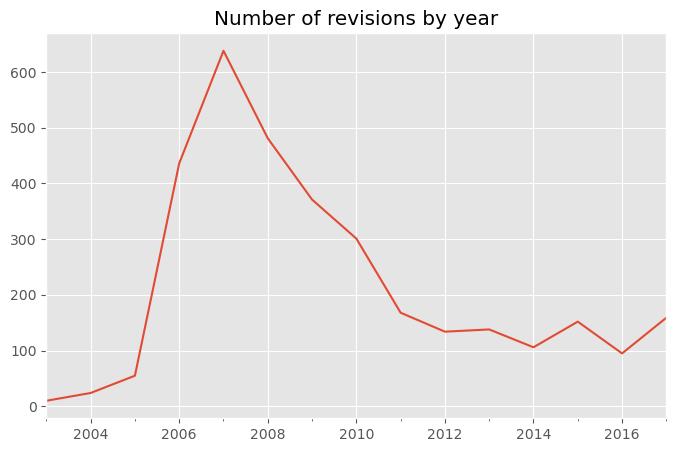

In [55]:
revByYear = tsRevWiki.resample('Y').count()
revByYear.plot(figsize=(8,5), title="Number of revisions by year")
plt.show()

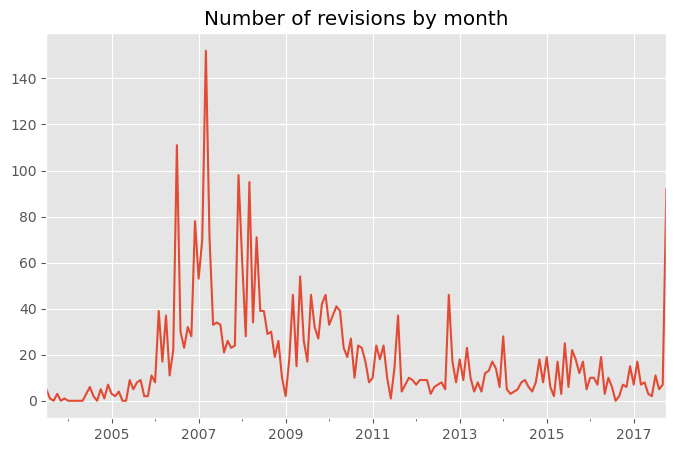

In [56]:
revByMonth = tsRevWiki.resample('M').count()
revByMonth.plot(figsize=(8,5), title="Number of revisions by month")
plt.show()

We can always **smooth** the data by making the interval bigger, for example, 3 months:

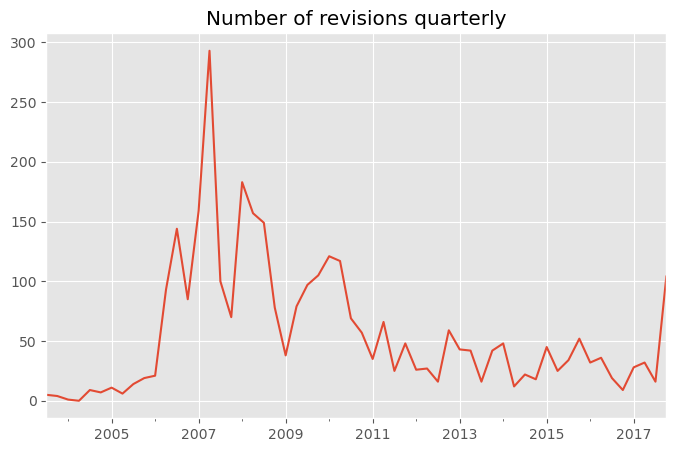

In [57]:
revByThreeMonths = tsRevWiki.resample('3M').count()
revByThreeMonths.plot(figsize=(8,5), title="Number of revisions quarterly")
plt.show()

We can focus on a single year, for example, 2007:

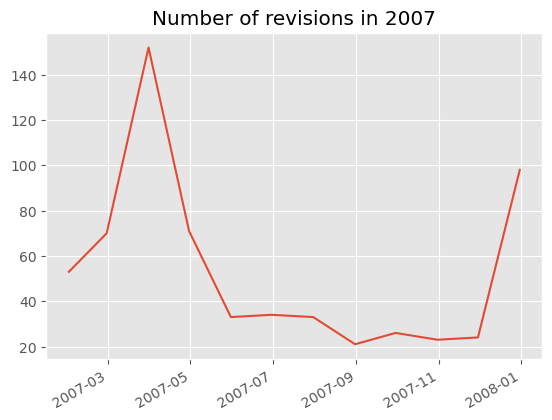

In [58]:
revsIn2007 = tsRevWiki['2007']
revsIn2007Months = revsIn2007.resample('M').count()
revsIn2007Months.plot(title="Number of revisions in 2007", # not using figsize
                      x_compat=True # this parameter suppresses how often the xticks are displayed
                     ) 
plt.show()

The same way, we can zoom in in the month of October 2017:

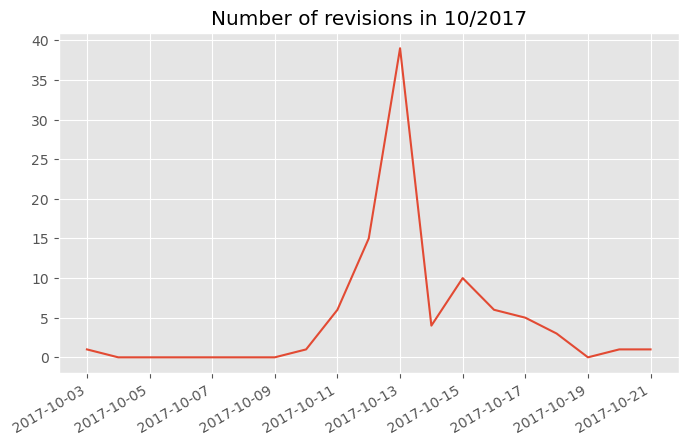

In [59]:
revsOct17 = tsRevWiki['2017-10']
revsOct17Day = revsOct17.resample('D').count()
revsOct17Day.plot(figsize=(8,5), 
                  title="Number of revisions in 10/2017",
                  x_compat=True)
plt.show()

### Find most active editing days

Given that we can create a series based on daily edit counts, we can find the day with most edits:

In [40]:
revByDays = tsRevWiki.resample('D').count()
revByDays.sort_values(ascending=False).head(10)

2006-07-27    70
2017-10-13    39
2007-12-15    26
2007-03-25    24
2006-12-30    18
2012-10-28    17
2007-12-31    17
2007-03-10    17
2009-12-01    16
2012-10-29    16
dtype: int64

We can see how 2017/10/13, one of the days in the evolving Harvey Weinstein story, has the second largest number of edits.

### Find most active editors

In order to find editors, we will create a dataframe from the series, in order to use the method `groupby` which works better on dataframes.

Notice that we can create the dataframe using the columns of the timeseries tsRevWiki.

In [41]:
dfWiki = DataFrame({'editors': tsRevWiki}, 
                     index=tsRevWiki.index)
dfWiki.head()

,editors
2017-10-21 09:32:02,RichardBond
2017-10-20 11:58:49,Eamontopleez
2017-10-18 17:50:47,Drmies
2017-10-18 01:13:04,User No. 99
2017-10-18 00:00:14,Gene2010


In [42]:
dfWiki.shape

(3268, 1)

Now we can use the method `groupby` that will group together values in the column 'editors', find how often each editor occurs and show that value in a new column, "total":

In [43]:
dfWikiT = dfWiki.groupby('editors').size().reset_index(name="total")
dfWikiT.head(10)

,editors,total
0,*Kat*,1
1,100.0.71.51,1
2,100.38.207.221,1
3,101.103.164.193,1
4,101.184.225.1,1
5,104.175.43.228,3
6,108.17.25.115,1
7,108.180.17.36,1
8,108.181.180.120,1
9,108.2.173.243,1


In [44]:
dfWikiT.shape

(1468, 2)

We can see that the number of rows in this new dataframe is smaller, since some editors have more than one edit.

By the way, editor names such as 108.2.173.243, refer to the IP address of an editor. If someone edits a Wiki page without using an account, the system automatically captures their IP address.

Let's sort to find the most prolific editors:

In [45]:
dfWikiT.sort_values('total', ascending=False)[:10]

,editors,total
436,68.190.48.20,81
471,69.142.14.136,66
1229,Nymf,53
1434,Wildhartlivie,51
1167,Magnius,49
1456,Z-vap,42
1394,Treybien,39
255,213.105.222.232,38
1112,KellyAna,31
608,77.98.184.35,26


### Focus on one editor

Let's look at the behavior of a single editor, for example, Nymf (third most active):

In [46]:
oneUser = dfWiki[dfWiki['editors']=='Nymf'] # select from the frame the rows that fulfill the query
oneUser.head()

,editors
2015-10-02 09:28:50,Nymf
2015-08-26 15:27:46,Nymf
2015-06-12 04:49:12,Nymf
2014-04-26 21:08:36,Nymf
2014-04-17 19:07:24,Nymf


We can resample the events by year and plot the timeseries:

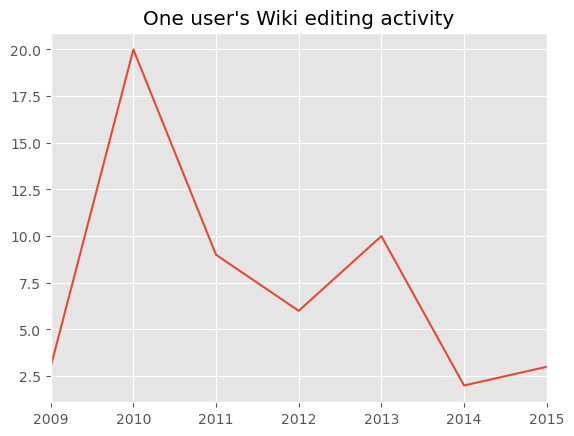

In [60]:
oneUser.resample('Y').count().plot(legend=False, title="One user's Wiki editing activity")
plt.show()

Similarly, we can do this with grouping by year:

In [ ]:
oneUser.groupby(oneUser.index.year).count()

This shows that this user was active on 7 different years.

### Find page creator

Who created the page of Rose McGowan? We can find this info from the time series.

In [48]:
dfWiki.tail(5)

,editors
2003-07-07 18:12:48,Sannse
2003-07-06 22:42:34,Sannse
2003-07-03 19:10:21,Easterbradford
2003-07-03 17:27:25,68.16.134.146
2003-07-03 17:26:34,68.16.134.146


In [49]:
creator = dfWiki['editors'].iloc[-1]
creator

'68.16.134.146'

In [50]:
dfWiki[dfWiki['editors']==creator]

,editors
2003-07-03 17:27:25,68.16.134.146
2003-07-03 17:26:34,68.16.134.146


This user only created the page and then never returned to make edits to it. Or, they created a username and then used that to do their edits.

<a id="sec5"></a>

## 5. Tasks for you: Dobbs v. Jackson

To complete these tasks, you need to have completed that last task on the "Getting data from Wikipedia" notebook, which creates a file titled `dobbsVJacksonRevisions.json`. If you have that file, you can continue with the following tasks:

1. Load the JSON file.
2. Create a timeseries for this data, similarly to what you did for Rose McGowan's page
3. Create the visualization of the timeseries for two different frequencies: monthly and daily.
4. Comparing the two visualizations from point 3 what is the value of each of them?
5. **Challenge:** One of the most interesting visualization of timeseries are [sparklines](https://en.wikipedia.org/wiki/Sparkline). For the five most active users, try to create a sparklines graph using [this Plotly chart](https://plotly.com/python/line-charts/#sparklines-with-plotly-express). [This is challenging, because you'll have to create a new dataframe, which requires some thinking. Try it, if you like a good challenge.]

<a id="sec6"></a>

In [ ]:
with open('dobbsVJacksonRevisions.json', 'r') as file:
    dobbs_data = json.load(file)